In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from plotting import plot_decision_boundary
from pprint import pprint

In [9]:
x, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((120, 4), (120,), (30, 4), (30,))

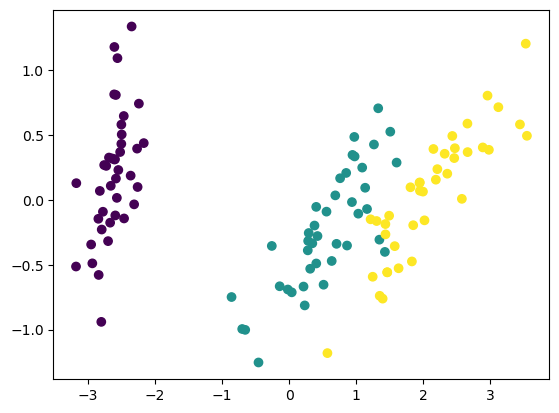

In [10]:
pca = PCA(n_components=2, random_state=42)
pca.fit(x_train)
x_train_transformed = pca.transform(x_train)
x_test_transformed = pca.transform(x_test)

plt.scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y_train)
plt.show()

In [11]:
def objective(trial):
    # Selection of model
    clf = trial.suggest_categorical("clf", ["svc", "linear_svc", "nu_svc"])

    # Selection of kernel
    SVC_KERNEL = ["linear", "poly", "rbf", "sigmoid"]

    # Parameters for SVC
    if clf == "svc":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e2, log=True)  
        svc_kernel = trial.suggest_categorical("svc_kernel", SVC_KERNEL)

        # Parameters for SVC polynomial kernel
        if svc_kernel == "poly":
            svc_degree = trial.suggest_int("svc_degree", 1, 20)
            clf_obj = SVC(C=svc_c, kernel=svc_kernel, degree=svc_degree)

        # Parameters for SVC non-polynomial kernel
        else:
            clf_obj = SVC(C=svc_c, kernel=svc_kernel)

    # Parameters for LinearSVC
    elif clf == "linear_svc":
        linear_svc_penalty = trial.suggest_categorical("linear_svc_penalty", ["l1", "l2"])
        linear_svc_c = trial.suggest_float("linear_svc_c", 1e-10, 1e2, log=True)  
        clf_obj = LinearSVC(penalty=linear_svc_penalty, C=linear_svc_c, dual=False)

    # Parameters for NuSVC
    else:
        nu_svc_kernel = trial.suggest_categorical("nu_svc_kernel", SVC_KERNEL)

        # Parameters for NuSVC polynomial kernel
        if nu_svc_kernel == "poly":
            nu_svc_degree = trial.suggest_int("nu_svc_degree", 1, 20)
            clf_obj = NuSVC(kernel=nu_svc_kernel, degree=nu_svc_degree)

        # Parameters for NuSVC non-polynomial kernel
        else:
            clf_obj = NuSVC(kernel=nu_svc_kernel)

    # Create a pipeline with scaling
    pipeline = make_pipeline(StandardScaler(), clf_obj)

    # Cross-validate the model and return the average accuracy
    accuracy = cross_val_score(pipeline, x_train_transformed, y_train, cv=3, scoring="accuracy").mean()

    return accuracy  


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

[I 2024-09-29 16:59:03,899] A new study created in memory with name: no-name-92b2c87f-20bb-4492-ac3c-d785ee8caf8b
[I 2024-09-29 16:59:03,912] Trial 0 finished with value: 0.7583333333333334 and parameters: {'clf': 'nu_svc', 'nu_svc_kernel': 'poly', 'nu_svc_degree': 13}. Best is trial 0 with value: 0.7583333333333334.
[I 2024-09-29 16:59:03,925] Trial 1 finished with value: 0.5583333333333333 and parameters: {'clf': 'svc', 'svc_c': 3.97855212099242e-10, 'svc_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7583333333333334.
[I 2024-09-29 16:59:03,933] Trial 2 finished with value: 0.3333333333333333 and parameters: {'clf': 'linear_svc', 'linear_svc_penalty': 'l1', 'linear_svc_c': 3.517433099379215e-07}. Best is trial 0 with value: 0.7583333333333334.
[I 2024-09-29 16:59:03,945] Trial 3 finished with value: 0.5499999999999999 and parameters: {'clf': 'svc', 'svc_c': 1.079516647420656e-09, 'svc_kernel': 'rbf'}. Best is trial 0 with value: 0.7583333333333334.
[I 2024-09-29 16:59:03,953] Tr

In [12]:
pprint(study.best_params)
pprint(study.best_value)

{'clf': 'svc', 'svc_c': 1.7221168135134777, 'svc_kernel': 'linear'}
0.975


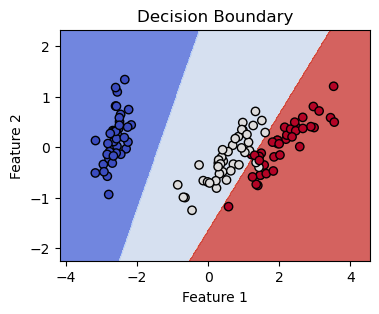

In [13]:
c = study.best_params["svc_c"]
kernel = study.best_params["svc_kernel"]
model = SVC(C=c, kernel=kernel)
model.fit(x_train_transformed, y_train)


fig, ax = plt.subplots(figsize=(4, 3))
plot_decision_boundary(model, x_train_transformed, y_train, ax=ax)

In [14]:
y_pred = model.predict(x_test_transformed)

acc = (y_pred == y_test).mean()
acc

0.9333333333333333